In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from tqdm import tqdm
import seaborn as sns
import librosa
from librosa import display
import os
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from tensorflow.keras.utils import plot_model
import warnings
warnings.filterwarnings('ignore', category=UserWarning)

import random

# Set seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)
random.seed(42)

2024-11-30 10:46:17.364456: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-11-30 10:46:17.940051: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


# Normalized features

In [2]:


# Define the path to your dataset
dataset_path = "/home/muzaffar/Desktop/Research/papers/hybrid-word-spken-paper(ablation)/original-data-3630"

# Initialize lists to hold features and labels
feature_list = []
label_list = []

# Define a function to normalize the mel spectrogram
def normalize_mel_spectrogram(mel_spectrogram):
    mel_spectrogram_db = librosa.power_to_db(S=mel_spectrogram, ref=1.0)
    return (mel_spectrogram_db - np.mean(mel_spectrogram_db)) / np.std(mel_spectrogram_db)

# Define a fixed size for padding (e.g., 128 time steps)
fixed_size = 32

# Update the feature extraction process
for class_folder in os.listdir(dataset_path):
    class_path = os.path.join(dataset_path, class_folder)

    for file in tqdm(os.listdir(class_path)):
        if not file.endswith('.wav'):
            continue

        audio_path = os.path.join(class_path, file)
        audio, sr = librosa.load(path=audio_path, sr=None)
        
        # Avoid using time_stretch unless intended
        # audio = librosa.effects.time_stretch(y=audio, rate=len(audio)/sr)

        mels = librosa.feature.melspectrogram(y=audio, sr=sr, n_fft=2048, hop_length=512)
        normalized_mels = normalize_mel_spectrogram(mels)

        # Pad or truncate to fixed size
        if normalized_mels.shape[1] < fixed_size:
            # Pad with zeros
            pad_width = fixed_size - normalized_mels.shape[1]
            padded_mels = np.pad(normalized_mels, ((0, 0), (0, pad_width)), mode='constant')
        else:
            # Truncate to fixed size
            padded_mels = normalized_mels[:, :fixed_size]

        feature_list.append(padded_mels.T)
        label_list.append(class_folder)

# Convert to NumPy arrays
features = np.array(feature_list)
labels = np.array(label_list)

print("Feature shape:", features.shape)
print("Label shape:", labels.shape)


100%|██████████| 364/364 [00:00<00:00, 535.44it/s]

Feature shape: (3630, 32, 128)
Label shape: (3630,)


In [3]:

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Set parameters for data splitting and training
TEST_SIZE = 0.2
RANDOM_STATE = 42  # For reproducibility

# Encode Labels (from strings to integers)
label_encoder = LabelEncoder()
integer_labels = label_encoder.fit_transform(labels)

# One-hot encode the integer labels
encoded_labels = tf.one_hot(indices=integer_labels, depth=len(label_encoder.classes_))

from sklearn.model_selection import train_test_split

# Perform stratified split
X_train, X_test, y_train, y_test = train_test_split(
    features, 
    encoded_labels.numpy(), 
    test_size=TEST_SIZE, 
    random_state=RANDOM_STATE, 
    stratify=integer_labels  # Stratify ensures balanced splits for each class
)


print("Train, validation, and test data prepared successfully.")


2024-11-30 10:46:26.289554: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-11-30 10:46:26.326791: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-11-30 10:46:26.326982: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

Train, validation, and test data prepared successfully.


L355
2024-11-30 10:46:26.328125: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-11-30 10:46:26.328247: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-11-30 10:46:26.388741: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#

In [4]:
features[1].shape

(32, 128)

In [5]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dropout, Dense, Flatten
from tensorflow.keras.optimizers import Adam
import tensorflow as tf

initializer = tf.keras.initializers.GlorotUniform(seed=42)

# Define input shape (128 Mel-bands x 32 time steps for Mel-spectrogram)
INPUT_SHAPE = (32, 128)

# Define number of classes
NUM_CLASSES = encoded_labels.shape[1]

# Initialize the Sequential model
model2 = Sequential()

# Add the first GRU layer with 32 units, 'ReLU' activation
model2.add(GRU(units=64, activation='relu', kernel_initializer=initializer, return_sequences=True, input_shape=INPUT_SHAPE))
model2.add(Dropout(0.3))  # Dropout to reduce overfitting

# Add the second GRU layer with 32 units
model2.add(GRU(units=64, activation='relu', kernel_initializer=initializer))
model2.add(Dropout(0.3))

# Add a Dense layer with 32 units and 'ReLU' activation
model2.add(Dense(units=32, kernel_initializer=initializer, activation='relu'))
model2.add(Dropout(0.3))

# Output layer with 'softmax' activation for multi-class classification
model2.add(Dense(units=NUM_CLASSES, kernel_initializer=initializer, activation='softmax'))

# Print the model summary
model2.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru (GRU)                       │ (None, 32, 64)         │        37,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_1 (GRU)                     │ (None, 64)             │        24,960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │           330 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 64,618 (252.41 KB)

 Trainable params: 64,618 (252.41 KB)

 Non-trainable params: 0 (0.00 B)

In [6]:

%%time
# Compile the model with 'categorical_crossentropy' loss and 'Adam' optimizer
model2.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])


# Configure the training parameters: 100 epochs and batch size of 16
history = model2.fit(X_train, y_train, epochs=100, batch_size=16, validation_split=0.1,  # 10% of training data used for validation
    shuffle=True)

Epoch 1/100


I0000 00:00:1732943788.981429   69256 service.cc:145] XLA service 0x7f6ee800b340 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1732943788.981451   69256 service.cc:153]   StreamExecutor device (0): NVIDIA GeForce GTX 1080 Ti, Compute Capability 6.1
2024-11-30 10:46:29.025802: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-11-30 10:46:29.226011: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8906


 25/164 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.1099 - loss: 2.3288

I0000 00:00:1732943791.707293   69256 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


164/164 ━━━━━━━━━━━━━━━━━━━━ 9s 27ms/step - accuracy: 0.1104 - loss: 2.3173 - val_accuracy: 0.1134 - val_loss: 2.3018
Epoch 2/100
164/164 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.1315 - loss: 2.2754 - val_accuracy: 0.1993 - val_loss: 2.1888
Epoch 3/100
164/164 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.1958 - loss: 2.1327 - val_accuracy: 0.3265 - val_loss: 1.7802
Epoch 4/100
164/164 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.3334 - loss: 1.7777 - val_accuracy: 0.4639 - val_loss: 1.3987
Epoch 5/100
164/164 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.4513 - loss: 1.4858 - val_accuracy: 0.5979 - val_loss: 1.1483
Epoch 6/100
164/164 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.5494 - loss: 1.2635 - val_accuracy: 0.6907 - val_loss: 0.9389
Epoch 7/100
164/164 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.6617 - loss: 1.0072 - val_accuracy: 0.8007 - val_loss: 0.6009
Epoch 8/100
164/164 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7297 - loss: 0.8074 - val_accuracy: 0.811

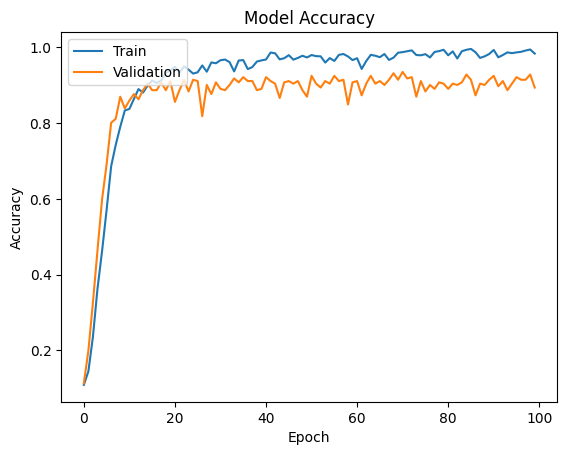

23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step
Classification Report:
              precision    recall  f1-score   support

         Akh       0.95      0.76      0.85        72
         Zie       0.76      0.85      0.80        72
       Thrre       0.71      0.95      0.81        73
        Tsor       0.84      0.88      0.86        73
       Pancs       0.90      0.82      0.86        73
        Shae       0.98      0.71      0.82        72
        Sath       0.86      0.86      0.86        73
      Eahght       0.89      0.89      0.89        73
         Nav       0.85      0.86      0.86        72
        Daah       0.86      0.90      0.88        73

    accuracy                           0.85       726
   macro avg       0.86      0.85      0.85       726
weighted avg       0.86      0.85      0.85       726



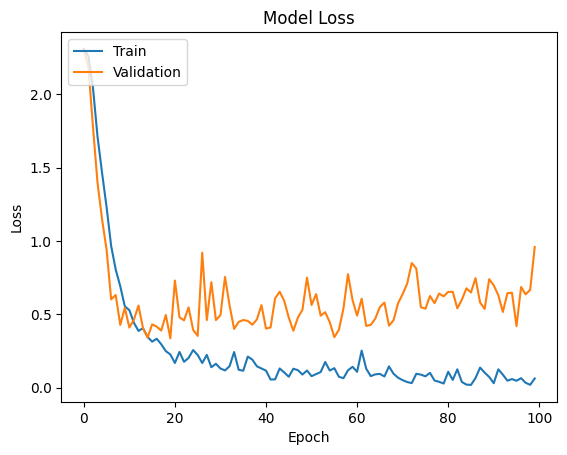

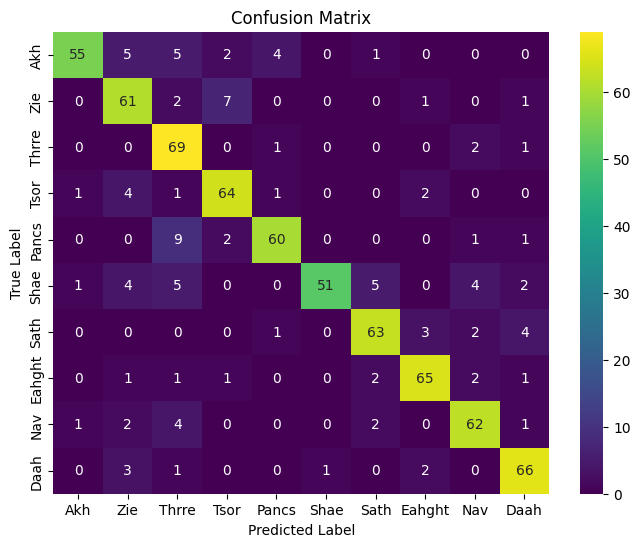

In [7]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf

# Plot the training and validation accuracy over the epochs
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot the training and validation loss over the epochs
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Step 1: Make predictions on the test set
y_pred_probs = model2.predict(X_test)  # Outputs probabilities

# Step 2: Convert predicted probabilities to class labels (using argmax)
y_pred = np.argmax(y_pred_probs, axis=1)  # Predicted class labels
y_true = np.argmax(y_test, axis=1)        # True class labels (from one-hot to integer labels)

# Step 3: Generate classification report
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=['Akh', 'Zie', 'Thrre', 'Tsor', 'Pancs', 'Shae', 'Sath', 'Eahght', 'Nav', 'Daah']))

# Step 4: Compute and plot confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred, labels=range(10))

plt.figure(figsize=(8, 6))
custom_ticks = ['Akh', 'Zie', 'Thrre', 'Tsor', 'Pancs', "Shae", "Sath", "Eahght", "Nav", "Daah"]
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='viridis', xticklabels=custom_ticks, yticklabels=custom_ticks)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

plt.show()


In [8]:


loss, accuracy = model2.evaluate(X_test, y_test, batch_size=16)
print('Test loss:', loss)
print('Test accuracy:', accuracy)

46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8553 - loss: 0.9817
Test loss: 1.2091546058654785
Test accuracy: 0.8484848737716675


In [9]:
from sklearn.metrics import classification_report, accuracy_score

# Step 1: Use your model to make predictions on the test set
y_pred = model2.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)  # Convert softmax output to class labels

# Step 2: Convert one-hot encoded true labels back to class labels
y_true_classes = np.argmax(y_test, axis=1)

# Step 3: Calculate the accuracy for the overall model
overall_accuracy = accuracy_score(y_true_classes, y_pred_classes)
print(f"Overall Accuracy: {overall_accuracy:.4f}")

# Step 4: Generate a classification report
report = classification_report(y_true_classes, y_pred_classes, target_names=custom_ticks, output_dict=True)

# Step 5: Print metrics for each class
for class_name in custom_ticks:
    print(f"\nMetrics for class '{class_name}':")
    print(f"Precision: {report[class_name]['precision']:.4f}")
    print(f"Recall: {report[class_name]['recall']:.4f}")
    print(f"F1-Score: {report[class_name]['f1-score']:.4f}")
    print(f"Support: {report[class_name]['support']}")  # Number of true instances for each class


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 862us/step
Overall Accuracy: 0.8485

Metrics for class 'Akh':
Precision: 0.9483
Recall: 0.7639
F1-Score: 0.8462
Support: 72.0

Metrics for class 'Zie':
Precision: 0.7625
Recall: 0.8472
F1-Score: 0.8026
Support: 72.0

Metrics for class 'Thrre':
Precision: 0.7113
Recall: 0.9452
F1-Score: 0.8118
Support: 73.0

Metrics for class 'Tsor':
Precision: 0.8421
Recall: 0.8767
F1-Score: 0.8591
Support: 73.0

Metrics for class 'Pancs':
Precision: 0.8955
Recall: 0.8219
F1-Score: 0.8571
Support: 73.0

Metrics for class 'Shae':
Precision: 0.9808
Recall: 0.7083
F1-Score: 0.8226
Support: 72.0

Metrics for class 'Sath':
Precision: 0.8630
Recall: 0.8630
F1-Score: 0.8630
Support: 73.0

Metrics for class 'Eahght':
Precision: 0.8904
Recall: 0.8904
F1-Score: 0.8904
Support: 73.0

Metrics for class 'Nav':
Precision: 0.8493
Recall: 0.8611
F1-Score: 0.8552
Support: 72.0

Metrics for class 'Daah':
Precision: 0.8571
Recall: 0.9041
F1-Score: 0.8800
Support: 73.0


In [10]:
from sklearn.metrics import confusion_matrix

# Step 1: Use your model to make predictions on the test set
y_pred = model2.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)  # Convert softmax output to class labels

# Step 2: Convert one-hot encoded true labels back to class labels
y_true_classes = np.argmax(y_test, axis=1)

# Step 3: Calculate the confusion matrix
conf_matrix = confusion_matrix(y_true_classes, y_pred_classes, labels=range(len(custom_ticks)))

# Step 4: Calculate accuracy for each class
accuracies = {}
for i, class_name in enumerate(custom_ticks):
    true_positive = conf_matrix[i, i]
    total = np.sum(conf_matrix[i, :])  # Total instances for the class
    accuracy = true_positive / total if total > 0 else 0
    accuracies[class_name] = accuracy

# Step 5: Print the accuracy for each class
for class_name, accuracy in accuracies.items():
    print(f"Accuracy for class '{class_name}': {accuracy:.4f}")


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 863us/step
Accuracy for class 'Akh': 0.7639
Accuracy for class 'Zie': 0.8472
Accuracy for class 'Thrre': 0.9452
Accuracy for class 'Tsor': 0.8767
Accuracy for class 'Pancs': 0.8219
Accuracy for class 'Shae': 0.7083
Accuracy for class 'Sath': 0.8630
Accuracy for class 'Eahght': 0.8904
Accuracy for class 'Nav': 0.8611
Accuracy for class 'Daah': 0.9041


In [11]:
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score

# Step 1: Use your model to make predictions on the test set
y_pred = model2.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)  # Convert softmax output to class labels

# Step 2: Convert one-hot encoded true labels back to class labels
y_true_classes = np.argmax(y_test, axis=1)

# Step 3: Calculate the accuracy, precision, recall, and F1-score
accuracy = accuracy_score(y_true_classes, y_pred_classes)
precision = precision_score(y_true_classes, y_pred_classes, average='macro')  # Macro-averaging (unweighted average across classes)
recall = recall_score(y_true_classes, y_pred_classes, average='macro')
f1 = f1_score(y_true_classes, y_pred_classes, average='macro')

# Step 4: Print the classification report for detailed metrics
report = classification_report(y_true_classes, y_pred_classes, target_names=custom_ticks)
#print(report)

# Step 5: Print the average metrics
print(f"Average Accuracy: {accuracy:.4f}")
print(f"Average Precision: {precision:.4f}")
print(f"Average Recall: {recall:.4f}")
print(f"Average F1-Score: {f1:.4f}")


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 899us/step
Average Accuracy: 0.8485
Average Precision: 0.8600
Average Recall: 0.8482
Average F1-Score: 0.8488


In [12]:
#model2.save('exp-1-cnn.h5')
